<p style="font-size: 40px; font-weight: bold; text-align: center;">Titanic survival prediction project</p>

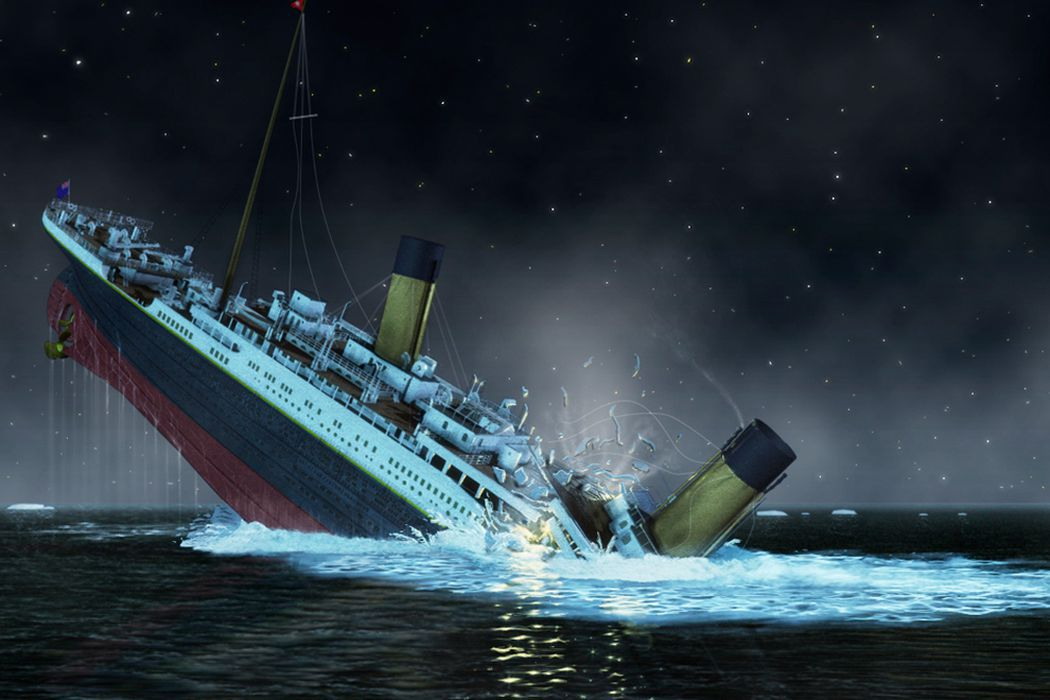

- <b>The Sinking of the Titanic and Building a Predictive Model to Understand Survival Factors</b>
    - The RMS Titanic, a British passenger liner operated by the White Star Line, sank in the North Atlantic Ocean on 15 April 1912 after striking an iceberg during its maiden voyage from Southampton, UK to New York City, United States. With an estimated 2,224 passengers and crew aboard, the disaster claimed over 1,500 lives, making it the deadliest sinking of a single ship up to that time. The Titanic was equipped with 16 lifeboat davits, each capable of lowering three lifeboats, for a total of 48 boats. However, the ship carried only 20 lifeboats, and four of them were collapsible and difficult to launch while the ship was sinking. When the ship sank, many of the lifeboats that had been lowered were only about half full.

    - The disaster was a turning point in maritime history and continues to capture public attention, providing inspiration for many artistic works. The sinking of the Titanic highlighted regulatory and procedural failures, which led to worldwide shock and outrage at the huge loss of life.

    - Using passenger data such as name, age, gender, socio-economic class, etc., we can build a predictive model to understand the factors that increased a person's chance of survival. While there was an element of luck involved in surviving, some groups of people were more likely to survive than others.

    - The disaster was met with worldwide shock and outrage, both at the huge loss of life and at the regulatory and procedural failures that had led to it. (from https://en.wikipedia.org/wiki/Titanic)

## Import libraries

In [33]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Model selection and evaluation libraries
from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV
)
from sklearn.metrics import (
    roc_auc_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score
)
from sklearn.metrics import classification_report

# Preprocessing libraries
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler
)

# Imputation libraries
from sklearn.impute import KNNImputer
from feature_engine.imputation import (
    ArbitraryNumberImputer,
    CategoricalImputer,
    MeanMedianImputer, 
    RandomSampleImputer
)

# Encoding libraries
from feature_engine.encoding import (
    CountFrequencyEncoder,
    OneHotEncoder,
    WoEEncoder as fe_WoEEncoder, 
    OrdinalEncoder,
    RareLabelEncoder, 
    PRatioEncoder
)

# Discretisation libraries
from feature_engine.discretisation import (
    DecisionTreeDiscretiser, 
    EqualFrequencyDiscretiser,
    EqualWidthDiscretiser
)

# Wrapper library
from feature_engine.wrappers import SklearnTransformerWrapper

# Pipeline library
from sklearn.pipeline import Pipeline

# Machine learning models libraries
from sklearn.ensemble import (
    GradientBoostingClassifier,
    RandomForestClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

# Others
pd.set_option('display.max_columns', None)
from typing import Tuple

# Ignore warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Functions

In [34]:
def categorical_numerical_splitter(df:pd.DataFrame()) -> Tuple[list,list]:
    '''
    This function separates variables 
    into numerical and categorical columns.
    
    Parameters:
        df : DataFrame, containing the data
        
    Return:
        cat: list, containing categorical column names.
        num: list, containing numerical column names.
    '''
    # Select the columns with dtype 'object' and convert them to a list
    cat = df.select_dtypes(include='object').columns.tolist()
    # Select all columns except the ones with dtype 'object' and convert them to a list
    num = df.select_dtypes(exclude='object').columns.tolist()
    
    # Return the lists of categorical and numerical column names
    return cat, num

In [35]:
def create_analysis_df(df:pd.DataFrame(), target:str, col:str) -> pd.DataFrame():
    '''
    This function creates a dictionary of values used to make a bar plot.
    
    Parameters:
        df (pd.DataFrame): The input dataframe.
        target (str): The target column for analysis.
        col (str): The column to be analyzed.
    
    Returns:
        pd.DataFrame : The df of values used to make the bar plot.
    '''
    
    # Create the dictionary with 'label', 'total', and 'survived' keys
    analysis_dict = {
        'label' : df[col].dropna().unique(),
        'total' : pd.Series(df[col].dropna().value_counts(),index=df[col].dropna().unique()).values,
        'survived' : pd.Series(df.groupby(col)[target].sum(),index=df[col].dropna().unique()).values
    }
    
    return pd.DataFrame(analysis_dict)

In [36]:
def survival_plot(df:pd.DataFrame(), target:str, col:str) -> None:
    '''
    This function plots a bar chart showing the total number 
    of observations for each unique value in the specified 
    column and the number of target values that are 1 for 
    each unique value in the specified column.
    
    Parameters:
    df: pd.DataFrame()
        The dataframe that contains the target and the column to be plotted
    target: str
        The target column name
    col: str
        The column to be plotted
        
    Returns: None
    '''
    # Create a dataframe to store the data for the bar plots
    analysis_dict = create_analysis_df(df,target,col)

    # Create a figure and axis for the bar plots
    fig, ax = plt.subplots(figsize=(12,6))

    # Plot the bar chart for the number of survivors by sex
    sns.barplot(
        data=pd.DataFrame(analysis_dict),
        x='label',
        y='survived',
        ax=ax, 
        color='black', 
        label='Survived'
    )
    # Plot the bar chart for the total number of passengers by sex
    sns.barplot(
        data=pd.DataFrame(analysis_dict),
        x='label',
        y='total',
        ax=ax,
        color='lightgreen',
        alpha=0.5, 
        label='Total'
    )

    # Set the title, labels, and legend of the bar plot
    ax.set_title(f'{col.capitalize()} survival Plot', fontsize=20)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.grid(axis='y', alpha=0.3)
    ax.legend(loc='best')

    # Show the plot
    plt.show()
    
    return None

In [37]:
def analysis_plot(
    df:pd.DataFrame(),
    target:str,
    x:str,
    hue:str,
    element:str = 'bars'
) -> tuple:
    '''
    Plot histograms of two subsets of data filtered by a target variable.
    
    Parameters:
        df (pandas dataframe): Data to be plotted.
        target (str): Column name in the dataframe to be used to filter the data into two subsets.
        x (str): Column name in the dataframe to be used as x-axis variable.
        hue (str): Column name in the dataframe to be used to create different colors for different categories.
    
    Returns:
        Tuple of matplotlib.axes._subplots.AxesSubplot: Subplots containing the histograms.
    '''
    # Create a figure with two subplots, arranged vertically
    fig, axes = plt.subplots(1, 2, figsize = (12, 6))
    
    # Plot the first histogram of data where target column is equal to 1
    sns.histplot(
        df[df[target]==1], 
        x = x, 
        hue = hue,
        stat = 'count',
        element = element, 
        ax = axes[0], 
        bins = 40 
    )

    # Plot the second histogram of data where target column is equal to 0
    sns.histplot(
        df[df[target]==0], 
        x = x, 
        hue = hue, 
        stat = 'count', 
        element = element,
        ax = axes[1], 
        bins = 40
    )
    
    # Set title and grid for the first subplot
    axes[0].set_title('Survived')
    axes[0].grid(axis='y')
    
    # Set title and grid for the second subplot
    axes[1].set_title('Not survived')
    axes[1].grid(axis='y')
    
    # return axes
    return axes[0],axes[1]

In [38]:
def create_model(
    algorithm_name:str,
    algorithm:'algorithm',
    df:pd.DataFrame()
) -> Pipeline:
    '''
    Create a model using the given algorithm_name and algorithm. 
    The model includes a pipeline of various preprocessing steps and the final algorithm.
    
    Parameters:
        algorithm_name (str): Name of the algorithm to be used.
        algorithm: The algorithm to be used.
    
    Returns:
        A pipeline of preprocessing steps and the final algorithm.
    '''
    # Create cat and num lists
    cat_list,num_list = categorical_numerical_splitter(df)
    
    # Create a pipeline object
    pipe = Pipeline([
        ('num_imputation_step',MeanMedianImputer(variables=num_list)),
        ('cat_imputation_step',CategoricalImputer(variables=cat_list)),
        ('discretiser_age',EqualWidthDiscretiser(variables=['age'])),
        ('discretiser_fare',EqualWidthDiscretiser(variables=['fare'])),
        ('rare_label_encoder',RareLabelEncoder(tol=0.1, n_categories=1, variables=cat_list)),
        ('encoder',OrdinalEncoder()),
        ('scaler',StandardScaler()),
        (algorithm_name,algorithm)
    ])
    
    return pipe

In [39]:
def create_param_grid(algorithm_name:str, parameters:dict)-> dict:
    '''
    Create a parameter grid for grid search 
    using a dictionary comprehension
    
    Parameters:
        algorithm_name: str, name of the algorithm
        parameters: dict, containing the parameter name and values
    
    Return:
        param_grid: dict, containing the parameter grid
    '''
    # using a dictionary comprehension instead of a for loop
    param_grid = {f"{algorithm_name}__{param}": val for param, val in parameters.items()}
    return param_grid

In [40]:
def registrate_score(
    container:dict(),
    grid_search:'Gridsearch_model',
    train:pd.DataFrame(),
    train_t:pd.DataFrame(),
    test:pd.Series(),
    test_t:pd.Series(),
    algorithm_name:str
) -> None:
    '''    
    This function is used to store the evaluation scores of different algorithms.
    It appends the following evaluation metrics for each algorithm:
        - algorithm name
        - training score (roc auc)
        - training precision score
        - testing score (roc auc)
        - testing precision score
        - best hyperparameters obtained through hyperparameter tuning

    Parameters:
        container (dict): The dictionary that stores the evaluation results of different algorithms
        grid_search (scikit-learn GridSearchCV object): The GridSearchCV object that contains the best hyperparameters for the algorithm
        train (pandas DataFrame): The training set
        train_t (pandas Series): The target variable for the training set
        test (pandas DataFrame): The testing set
        test_t (pandas Series): The target variable for the testing set
        algorithm_name (str): The name of the algorithm

    Returns:
        None
    '''
    container['algorithm_name'].append(algorithm_name)
    container['train_score_roc_auc'].append(grid_search.score(train,train_t))
    container['test_score_roc_auc'].append(grid_search.score(test,test_t))
    container['train_precision_score'].append(precision_score(y_train,grid_search.predict(train)))
    container['test_precision_score'].append(precision_score(y_test,grid_search.predict(test)))
    container['best_params'].append(grid_search.best_params_)
    
    return None

In [41]:
def eval_plot(scores:list, target:str)-> None:
    """
    Plot a barplot to compare train and test scores of algorithms
    
    Parameters:
        scores (dict): a dictionary that contains the scores and algorithm names
        target (str): the main target score to compare, either 'train_score' or 'test_score'
    
    Returns:
        None
    """
    fig, ax = plt.subplots(figsize=(16,5))
    
    data = pd.DataFrame(scores).sort_values(by=target,ascending=False)
    
    # map target score to secondary target score
    score_map = {
        'train_score_roc_auc': 'test_score_roc_auc',
        'test_score_roc_auc': 'train_score_roc_auc',
        'train_precision_score': 'test_precision_score',
        'test_precision_score': 'train_precision_score'
    }
    sec_target = score_map[target]
    
    # plot the main target score
    sns.barplot(
        data=data, 
        x=target, 
        y='algorithm_name', 
        palette='Paired', 
        ax=ax
    )
    
    # plot the secondary target score
    sns.barplot(
        data=data,
        x=sec_target,
        y='algorithm_name',
        palette='Paired', 
        alpha=0.2,
        ax=ax
    )
    
    # set plot title and formatting
    plt.title(f'{target.capitalize().replace("_", " ")} Metric Plot', fontsize=20)
    plt.grid(axis='x')
    ax.set_ylabel('')
    ax.set_xlabel('')
    plt.show()

## Data loading

In [42]:
# This line sets the maximum number of columns to be displayed in the output to 'None'
pd.set_option('display.max_columns',None)

# This line reads the 'titanic.csv' file and stores it in the variable 'data'
data = pd.read_csv('titanic.csv')

# Dropping useless columns
data.drop(columns=['boat','body','home.dest'],inplace=True)

## Exploratory data analysis

In [43]:
tmp_df = data[['pclass','age','survived','name']].copy()
tmp_df.survived = np.where(tmp_df.survived == 1,'survived','not_survived')

tmp_df.age = pd.concat([
    data[['pclass','age','survived']][data.pclass == 1].age.fillna(data[['pclass','age']][data.pclass == 1].age.mean()),
    data[['pclass','age','survived']][data.pclass == 2].age.fillna(data[['pclass','age']][data.pclass == 1].age.mean()),
    data[['pclass','age','survived']][data.pclass == 3].age.fillna(data[['pclass','age']][data.pclass == 1].age.mean()),
],axis=0).round(1)

tmp_df.name = tmp_df.name.str.split().str[1].str[:-1]
tmp_df.name = np.where(tmp_df.name.isin(list(tmp_df.name.value_counts().index[4:])),np.nan,tmp_df.name)

discretiser = EqualWidthDiscretiser(bins=5,variables=['age'])
tmp_df_discr = discretiser.fit_transform(tmp_df)

labels_list = (pd.Series(discretiser.binner_dict_['age'][1:-1]).round(1).values)
labels_list = np.insert(labels_list, 0, '-inf')
labels_list = np.append(labels_list, 'inf')
labels_list = list(labels_list)

label_dict = {number: labels_list[number:number + 2] for number in range(len(labels_list[:-1]))}

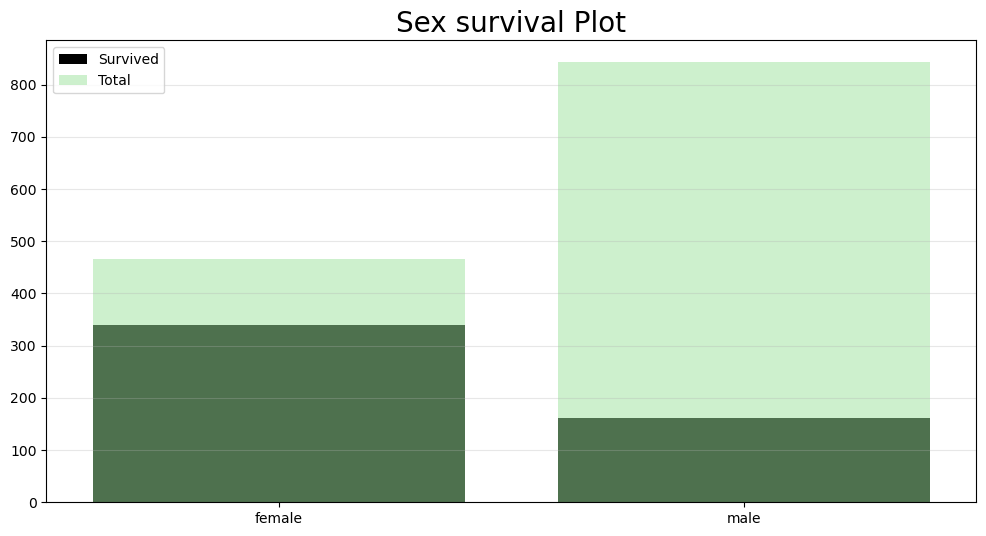

In [44]:
survival_plot(data,'survived','sex')

- <b>Conclusion</b>
    - This code creates a bar graph that displays the count of male and female passengers in a dataset, as well as the number of males and females who survived. The graph provides a visual illustration of the survival rate distribution based on gender. The chart reveals that a higher number of female passengers survived compared to male passengers.

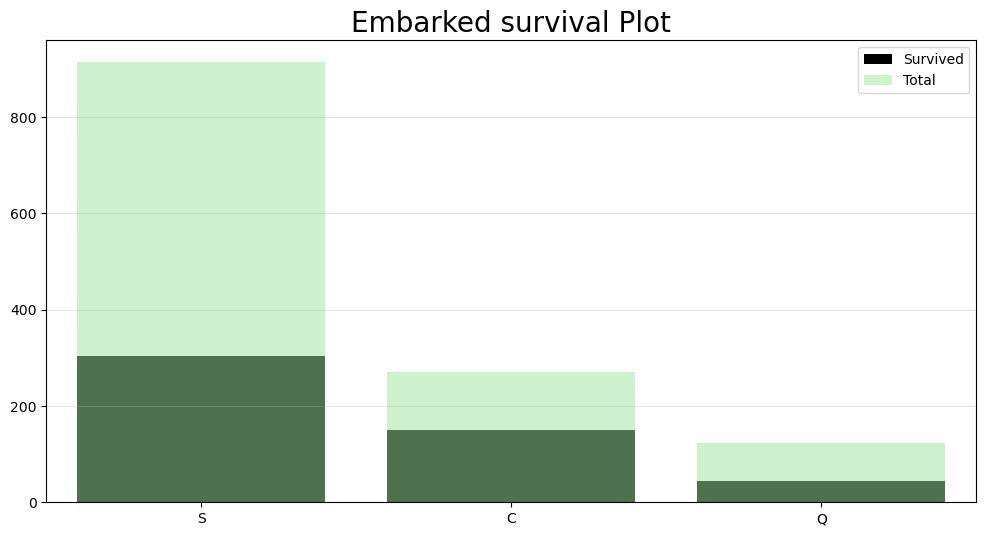

In [45]:
survival_plot(data,'survived','embarked')

- <b>Conclusion</b>
    - This code generates a bar graph showing the distribution of passenger survival based on their embarkation location. The graph displays both the total number of passengers and the number of survivors for each embarkation point. The graph provides insight into the distribution of the survival rate among different embarkation points.

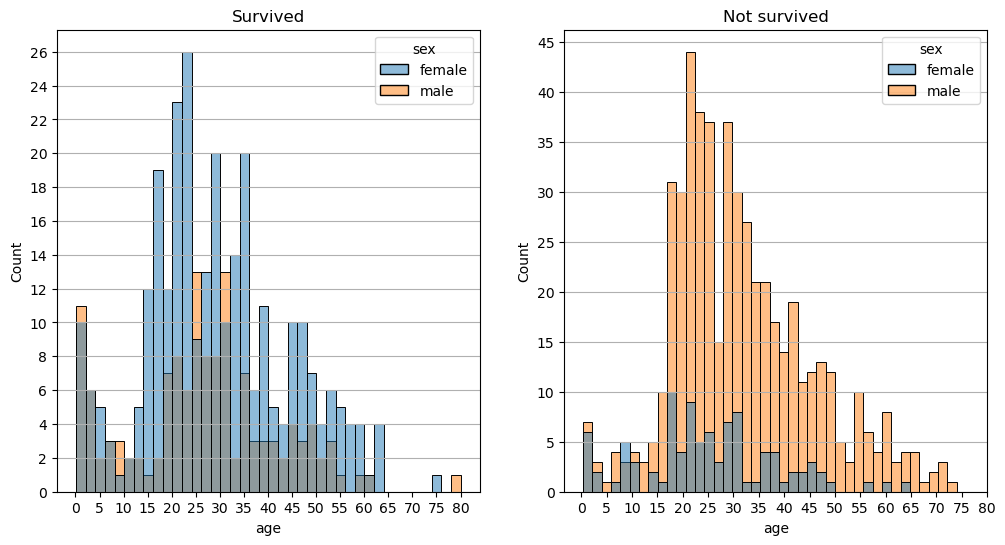

In [46]:
# Create analysis plot
axes = analysis_plot(data,'survived','age','sex')

axes[0].set_yticks(np.arange(0,28,2))
axes[0].set_xticks(np.arange(0,85,5))

axes[1].set_yticks(np.arange(0,46,5))
axes[1].set_xticks(np.arange(0,85,5))

# Show the figure
plt.show()

- <b>Conclusion</b>
    - The data from the images suggests that women were more likely to survive, with men only surviving in rare instances. The evidence also shows that a significant number of passengers perished, and that the number of men on the ship greatly outnumbered the number of women.

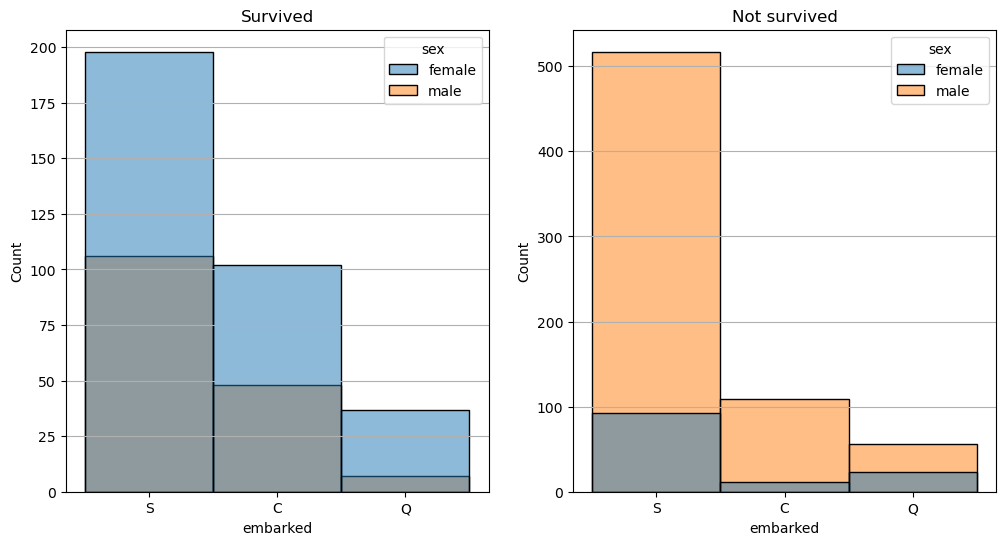

In [47]:
# Create analysis plot
axes = analysis_plot(data,'survived','embarked','sex')

# Show the figure
plt.show()

- <b>Conclusion</b>
    - Most passengers boarded the ship at the Southampton port.

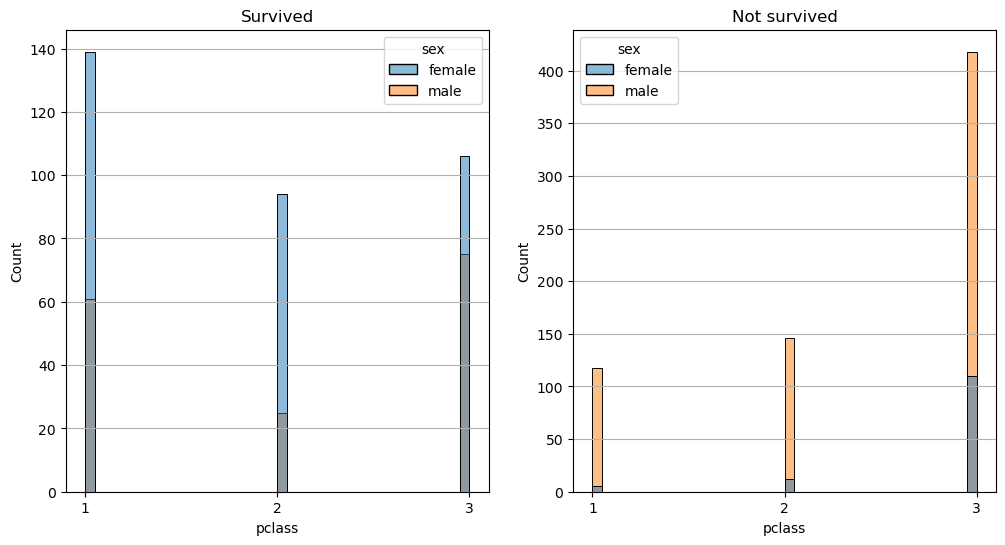

In [48]:
# Create analysis plot
axes = analysis_plot(data,'survived','pclass','sex')

axes[0].set_xticks([1,2,3])
axes[1].set_xticks([1,2,3])

# Show the figure
plt.show()

- <b>Conclusion</b>
    - First-class passengers had the highest survival rate, and the distribution among the classes was 25% of all passengers in 1st class, 21% in 2nd class, and 54% in 3rd class.

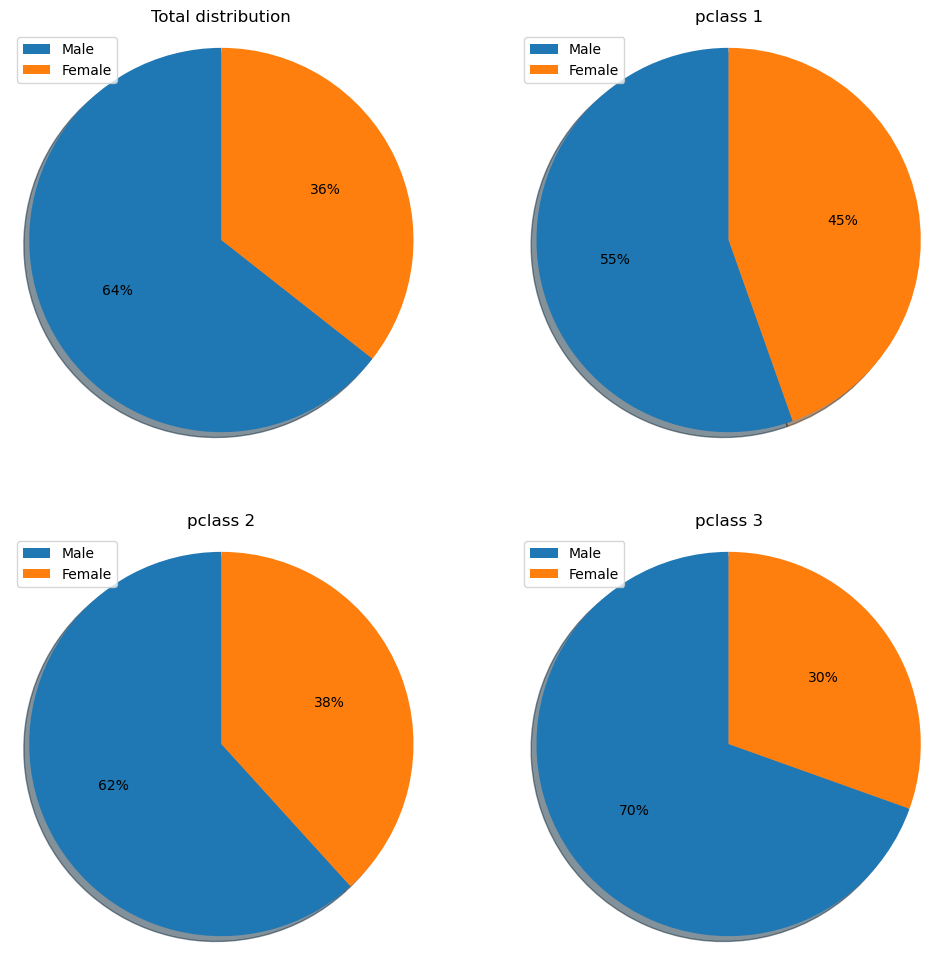

In [49]:
# Creating a figure with 2 rows and 2 columns
fig,axes = plt.subplots(nrows=2,ncols=2,figsize =(12,12))

# Defining the labels for the pie charts
labels = ['Male', 'Female']

# Plotting the pie chart for the total distribution of genders in the dataset
sizes = data[['sex','survived','pclass']].sex.value_counts().values
axes[0,0].pie(sizes, autopct='%.0f%%', shadow=True, startangle=90,)
axes[0,0].axis('equal') 
axes[0,0].legend(labels,loc = 'upper left')
axes[0,0].set_title('Total distribution') 

# Plotting the pie chart for the distribution of genders in pclass 1
sizes = data[['sex','survived','pclass']][data['pclass'] == 1].sex.value_counts().values
axes[0,1].pie(sizes, autopct='%.0f%%', shadow=True, startangle=90,)
axes[0,1].axis('equal')
axes[0,1].legend(labels,loc = 'upper left')
axes[0,1].set_title('pclass 1')

# Plotting the pie chart for the distribution of genders in pclass 2
sizes = data[['sex','survived','pclass']][data['pclass'] == 2].sex.value_counts().values
axes[1,0].pie(sizes, autopct='%.0f%%', shadow=True, startangle=90,)
axes[1,0].axis('equal')
axes[1,0].legend(labels,loc = 'upper left')
axes[1,0].set_title('pclass 2')

# Plotting the pie chart for the distribution of genders in pclass 3
sizes = data[['sex','survived','pclass']][data['pclass'] == 3].sex.value_counts().values
axes[1,1].pie(sizes, autopct='%.0f%%', shadow=True, startangle=90,)
axes[1,1].axis('equal')
axes[1,1].legend(labels,loc = 'upper left')
axes[1,1].set_title('pclass 3')

# Displaying the plot
plt.show()

- <b>Conclusion</b>
    - On board, there were 64% men and 36% women. Additionally, as the class increased, the presence of women became more common. For instance, in 1st class, the proportion of men to women was 55% to 45%, whereas in 3rd class it was 70% to 30%.

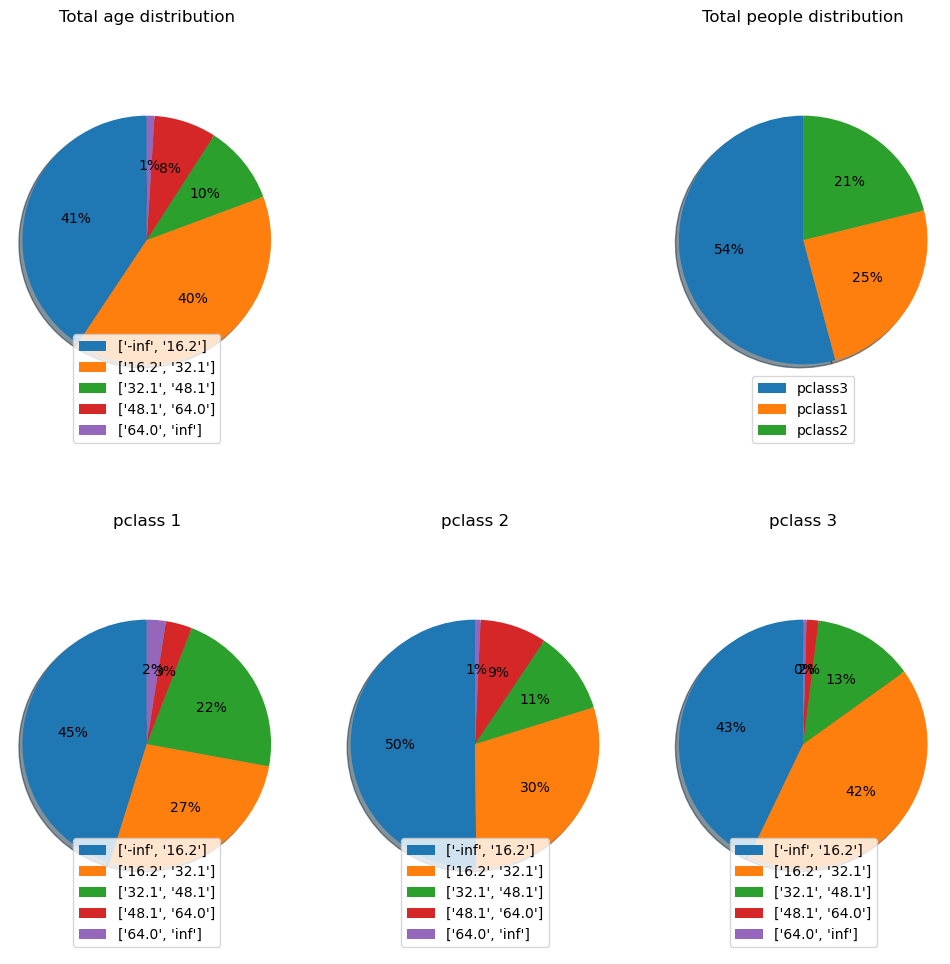

In [50]:
# Plotting a figure with subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 12))

# Hiding the second subplot in the first row
axes[0, 1].set_visible(False)

# Code for plotting pie charts for age distribution based on passenger class

# Pie chart for overall age distribution
sizes = tmp_df_discr.age.value_counts().values
axes[0,0].pie(sizes, autopct='%.0f%%', shadow=True, startangle=90,)
axes[0,0].axis('equal')
axes[0,0].legend(label_dict.values(),loc = 8)
axes[0,0].set_title('Total age distribution')

# Pie chart for overall passenger class distribution
sizes = tmp_df_discr.pclass.value_counts()
axes[0,2].pie(sizes, autopct='%.0f%%', shadow=True, startangle=90,)
axes[0,2].axis('equal')
axes[0,2].legend(['pclass3','pclass1','pclass2'],loc = 8)
axes[0,2].set_title('Total people distribution')

# Pie chart for age distribution of pclass 1
sizes = tmp_df_discr[tmp_df_discr.pclass == 1].age.value_counts().values
axes[1,0].pie(sizes, autopct='%.0f%%', shadow=True, startangle=90,)
axes[1,0].axis('equal')
axes[1,0].legend(label_dict.values(),loc = 8)
axes[1,0].set_title('pclass 1')

# Pie chart for age distribution of pclass 2
sizes = tmp_df_discr[tmp_df_discr.pclass == 2].age.value_counts().values
axes[1,1].pie(sizes, autopct='%.0f%%', shadow=True, startangle=90,)
axes[1,1].axis('equal')
axes[1,1].legend(label_dict.values(),loc = 8)
axes[1,1].set_title('pclass 2')

# Pie chart for age distribution of pclass 3
sizes = tmp_df_discr[tmp_df_discr.pclass == 3].age.value_counts().values
axes[1,2].pie(sizes, autopct='%.0f%%', shadow=True, startangle=90,)
axes[1,2].axis('equal')
axes[1,2].legend(label_dict.values(),loc = 8)
axes[1,2].set_title('pclass 3')

plt.show()

- <b>Conclusion</b>
    - About 80% of all passengers on the ship were in the age range of 0 to 32. Additionally, the first class had the highest number of elderly passengers aged over 64, which is likely a result of their financial stability. Similarly, the first class also had a larger number of passengers between the ages of 32 and 48, which suggests that these individuals have been successful in preserving their financial stability throughout their lives.

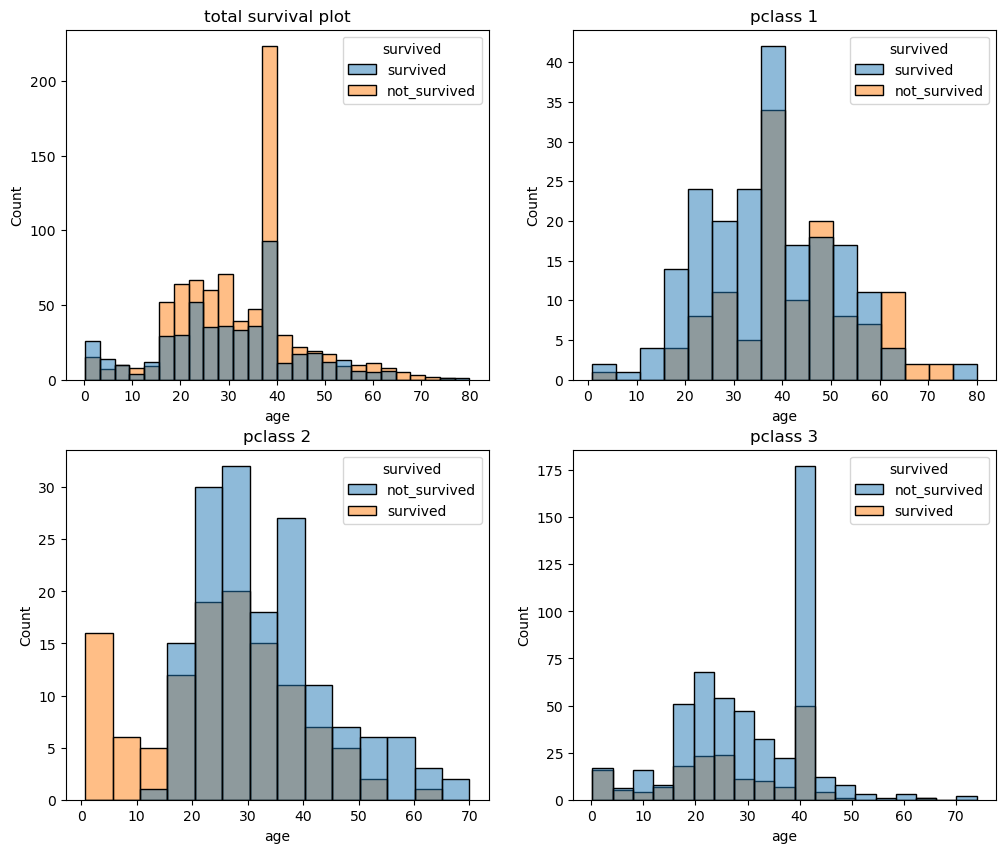

In [51]:
# Define the figure with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize = (12, 10))

# Plot histogram of age and survival in total dataset
sns.histplot(
    tmp_df[['age','survived']],
    x = 'age',
    hue = 'survived',
    stat= 'count',
    element= 'bars',
    ax= axes[0,0]
)
# Set the title of the plot
axes[0,0].set_title('total survival plot')

# Plot histogram of age and survival for passengers with pclass = 1
sns.histplot(
    tmp_df[['age','survived','pclass']][data['pclass'] == 1],
    x = 'age',
    hue = 'survived',
    stat= 'count',
    element= 'bars',
    ax = axes[0,1]
)
# Set the title of the plot
axes[0,1].set_title('pclass 1')

# Plot histogram of age and survival for passengers with pclass = 2
sns.histplot(
    tmp_df[['age','survived','pclass']][data['pclass'] == 2],
    x = 'age',
    hue = 'survived',
    stat= 'count',
    element= 'bars',
    ax = axes[1,0]
)
# Set the title of the plot
axes[1,0].set_title('pclass 2')

# Plot histogram of age and survival for passengers with pclass = 3
sns.histplot(
    tmp_df[['age','survived','pclass']][data['pclass'] == 3],
    x = 'age',
    hue = 'survived',
    stat= 'count',
    element= 'bars',
    ax = axes[1,1],
)
# Set the title of the plot
axes[1,1].set_title('pclass 3')

# Show the plots
plt.show()

- <b>Conclusion</b>
    - Most passengers were aged 35 to 40. Similarly, the majority of those who passed away were in the same age range. Children under 10 were more likely to survive than to perish. The largest group of children was in second class.

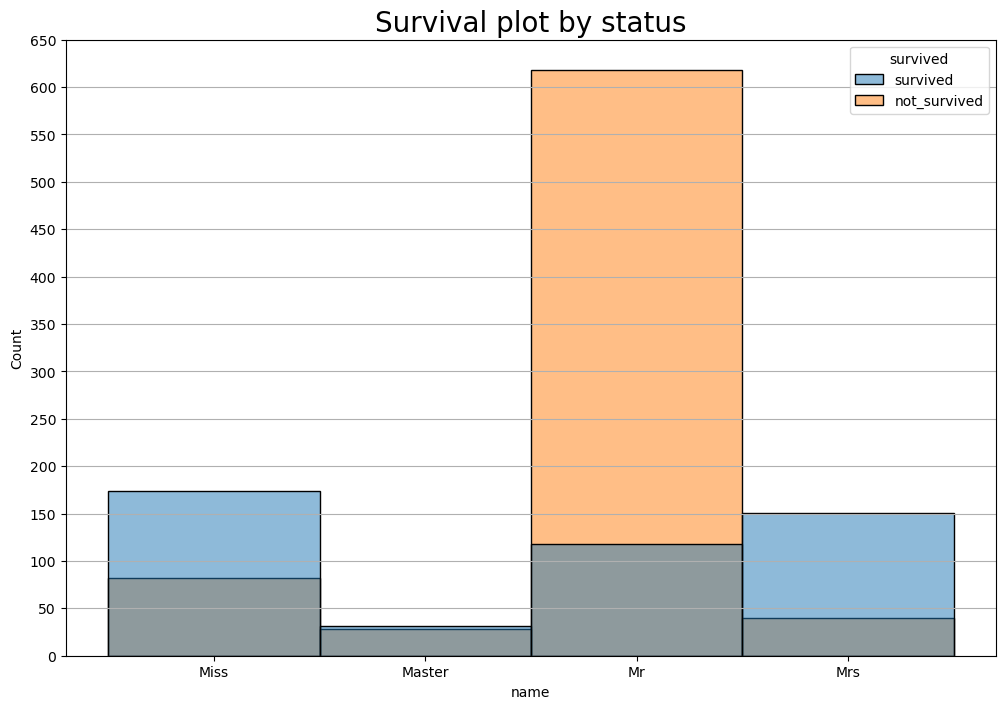

In [52]:
# Initialize figure with specified size
plt.figure(figsize=(12,8))

# Creating histogram plot using seaborn
sns.histplot(
    tmp_df[['age','survived','name']],
    x = 'name',
    hue = 'survived',
    stat= 'count',
)

# Adding title to the plot
plt.title('Survival plot by status',fontsize = 20)

# Setting y-axis tick values
plt.yticks(np.arange(0,700,50))

# Adding grid to y-axis
plt.grid(axis='y')

# Displaying the plot
plt.show()

- <b>Conclusion</b>
    - Most of the passengers who survived were female, with the status of "Miss" or "Mrs".

## Feature-engineering

In [21]:
# Name
'''
    Upon closely examining the values in the Name column, 
    a pattern can be observed that each name contains the 
    status of the passenger. While the column may not have
    direct relevance to the survival prediction, the status
    information will be beneficial, therefore it will be retained.
'''
cols = list(data.columns)
cols[2] = 'title'
data.columns = cols

data.title = data.title.str.split().str[1].str[:-1]
data.title = np.where(data.title.isin(list(data.title.value_counts().index[4:])),np.nan,data.title)

data.title.fillna('other',inplace=True)

In [22]:
# sibsp_and_parch
'''
    The sibsp and parch variables indicate the number of relatives
    on the ship, so these two variables can be merged into a 
    single one by taking their sum.
'''
data['sibsp_and_parch'] = data.parch + data.sibsp
data.drop(columns=['sibsp','parch'],inplace=True)

In [23]:
# Ticket
'''
    The "ticket" variable is a mixed data type, it needs to 
    be parsed first. Once parsed, it becomes evident which 
    passengers purchased their tickets together. Usually, 
    these passengers are members of a family.
'''
num_list = [str(i) for i in range(10)]
interpreted_labels = {}

for label in data.ticket.unique():
    interpreted_numbers = [index for index in label if index in num_list]
    interpreted_label = ''.join(interpreted_numbers)
    interpreted_labels[label] = interpreted_label
    
data.ticket = data.ticket.map(interpreted_labels)
group_list = [i for i in data.ticket.unique() if len(data[data.ticket == i]) > 1]
group_df = pd.DataFrame()

for ticket in group_list:
    group_df = pd.concat([group_df, data[data.ticket == ticket]], axis=0)
    
group_df = group_df.merge(data[['sex','title','age','survived','pclass']], left_index=True, right_index=True, how='left')
group_dict = {group: len(data[data.ticket == group]) for group in group_list}

not_mixed_labels = [label for label in data.ticket.unique() if all(c in num_list for c in label)]
not_mixed_label_dict = {label: label if label in not_mixed_labels else np.nan for label in data.ticket.unique()}

tmp_df = data[['cabin', 'survived']].copy()
tmp_df['not_mixed_label'] = data.ticket.map(not_mixed_label_dict)
tmp_df.cabin = tmp_df.cabin.astype(str).str[0]
tmp_df['ticket_type'] = np.where(~tmp_df.not_mixed_label.isnull(), '1', '0')

data['ticket_type'] = tmp_df['ticket_type']
data['group_qt'] = data['ticket'].map(group_dict).fillna('0')
data.drop(columns=['ticket'], inplace=True)
data.group_qt = data.group_qt.astype(int)
data.ticket_type = data.ticket_type.astype(int)
data.drop(columns=['cabin'],inplace=True)

In [24]:
# Embarked
''' 
    Replace the values in the 'embarked' column with their corresponding full names
    If the value is 'S', replace with 'Southampton'
    If the value is 'C', replace with 'Cherbourg'
    If the value is 'Q', replace with 'Queenstown'
    Otherwise, keep the original value
'''
data.embarked = np.where(
    data.embarked == 'S', 'Southampton',
    np.where(
        data.embarked == 'C', 'Cherbourg',
        np.where(
            data.embarked == 'Q', 'Queenstown',
            data.embarked)
    )
)

### Train/Test split

In [25]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['survived']),  
    data.survived, 
    test_size=0.3,
    random_state=0 
)

In [26]:
# This dictionary will store the evaluation results of different machine learning algorithms
evaluating_dict = {
    'algorithm_name':[],
    'train_score_roc_auc':[],
    'train_precision_score':[], 
    'test_score_roc_auc':[], 
    'test_precision_score':[],
    'best_params':[] 
}

In [27]:
# Define a dictionary containing algorithm name and algorithm class as value
algorithm_dict = {
    'GradientBoostingClassifier':GradientBoostingClassifier(),
    'DecisionTreeClassifier':DecisionTreeClassifier(),
    'RandomForestClassifier':RandomForestClassifier(),
    'KNeighborsClassifier':KNeighborsClassifier(),
    'XGBClassifier':XGBClassifier(),
    'GaussianNB':GaussianNB(),
    'SVC':SVC(),
}

In [28]:
# Define a dictionary containing additional hyperparameters for all algorithms
others_params = {
    'num_imputation_step__imputation_method':['mean','median'],
    'cat_imputation_step__imputation_method':['missing','frequent'],
    'discretiser_age__bins':[3,5,10],
    'discretiser_fare__bins':[3,5,10],
    'encoder':[
        OneHotEncoder(top_categories=1,drop_last=True),
        OneHotEncoder(top_categories=2,drop_last=True),
        OrdinalEncoder(),
        CountFrequencyEncoder()
    ],
    'scaler':[
        StandardScaler(),
        MinMaxScaler()
    ]
}

In [29]:
# Define a dictionary containing hyperparameters for each algorithm
param_dict = {
    'GradientBoostingClassifier': {
        'learning_rate': [0.1, 0.01, 0.001],  # The step size shrinkage used in update to prevent overfitting
        'min_samples_split': [2, 4, 6],  # The minimum number of samples required to split an internal node
        'min_samples_leaf': [1, 2, 4], # The minimum number of samples required to be at a leaf node
        'n_estimators': [20, 50, 100],  # The number of trees in the forest
        'max_depth': [2, 4, 6],  # The maximum depth of the tree
    },
    'RandomForestClassifier': {
        'min_samples_split': [2, 4, 6], # The minimum number of samples required to split an internal node
        'min_samples_leaf': [1, 2, 5], # The minimum number of samples required to be at a leaf node
        'criterion': ['gini', 'entropy'], # The function to measure the quality of a split
        'n_estimators': [20, 50, 100], # The number of trees in the forest
        'max_depth': [2, 4, 6], # The maximum depth of the tree
    },
    'DecisionTreeClassifier': {
        'min_samples_split': [2, 4, 6], # The minimum number of samples required to split an internal node
        'min_samples_leaf': [1, 2, 5],  # The minimum number of samples required to be at a leaf node
        'criterion': ['gini', 'entropy'],  # The function to measure the quality of a split.
        'max_depth': [2, 4, 6],  # The maximum depth of the tree
    },
    'KNeighborsClassifier': {
        'weights': ['uniform', 'distance'],  # Weight function used in prediction
        'n_neighbors': [1, 3, 5],  # Number of neighbors to use
        'p': [1, 2],  # Power parameter for the Minkowski metric
    },
    'XGBClassifier': {
        'colsample_bytree': [0.5, 0.8, 1],  # Subsample ratio of columns when constructing each tree
        'learning_rate': [0.1, 0.01, 0.001],  # Boosting learning rate (xgb’s “eta”)
        'subsample': [0.5, 0.8, 1],  # Subsample ratio of the training instances
        'n_estimators': [20, 50, 100],  # Number of trees in the forest
        'max_depth': [2, 4, 6],  # Maximum depth of a tree
    },
    'GaussianNB': {
        'var_smoothing': [1e-9, 1e-8, 1e-7],  # Portion of the largest variance of all features that is added to variances for calculation stability
    },
    'SVC': {
        'kernel': ['linear', 'poly', 'rbf'],  # Specifies the kernel type to be used in the algorithm
        'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
        'degree': [2, 3, 4],  # Degree of the polynomial kernel function
        'C': [0.1, 1, 10],  # Penalty parameter C of the error term
    }
}

In [30]:
'''
    The following code loops through an algorithms dictionary, 
    in which the names of the algorithms are the keys and the 
    algorithms themselves are the values. It uses the "create_model"
    function to make a model for each algorithm, the "create_param_grid"
    function to generate a parameter grid, the "GridSearchCV" function to 
    perform a grid search, and finally the "registrate_score" function to 
    register the score for each algorithm.
'''
# Training section
for number,(algorithm_name,algorithm) in enumerate(algorithm_dict.items()):
    print(f'Step : #{number}\nAlgorithm : {algorithm_name}')
    main_pipe = create_model(algorithm_name,algorithm,X_train)

    # Generating parameters
    param_grid = create_param_grid(algorithm_name,param_dict[algorithm_name])
    param_grid.update(others_params)
    
    # Perform a grid search using the GridSearchCV function
    grid_search = GridSearchCV(
        estimator=main_pipe,
        param_grid=param_grid,
        cv=5, 
        scoring='roc_auc', 
        n_jobs=-1, 
        error_score='raise'
    )
    
    # Fitting section
    print('Fitting model')
    grid_search.fit(X_train,y_train)
    
    # Registration section
    print('Registrating score')    
    registrate_score(
        evaluating_dict,
        grid_search,
        X_train,y_train,
        X_test,y_test,
        algorithm_name,
    )
    
    print('------')

Step : #0
Algorithm : GradientBoostingClassifier
Fitting model
Registrating score
------
Step : #1
Algorithm : DecisionTreeClassifier
Fitting model
Registrating score
------
Step : #2
Algorithm : RandomForestClassifier
Fitting model
Registrating score
------
Step : #3
Algorithm : KNeighborsClassifier
Fitting model
Registrating score
------
Step : #4
Algorithm : XGBClassifier
Fitting model
Registrating score
------
Step : #5
Algorithm : GaussianNB
Fitting model
Registrating score
------
Step : #6
Algorithm : SVC
Fitting model
Registrating score
------


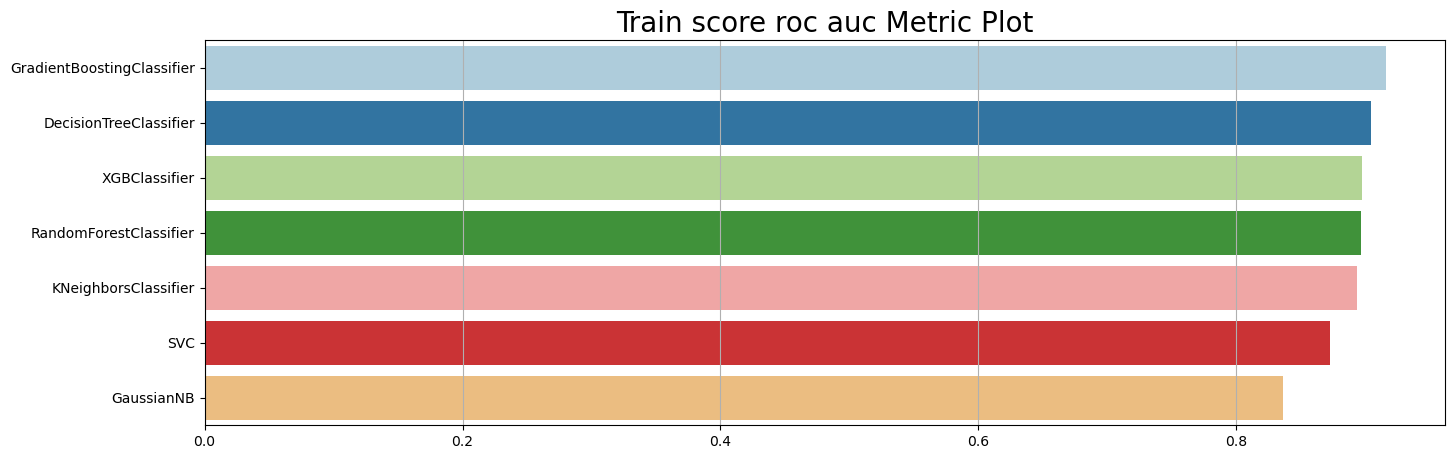

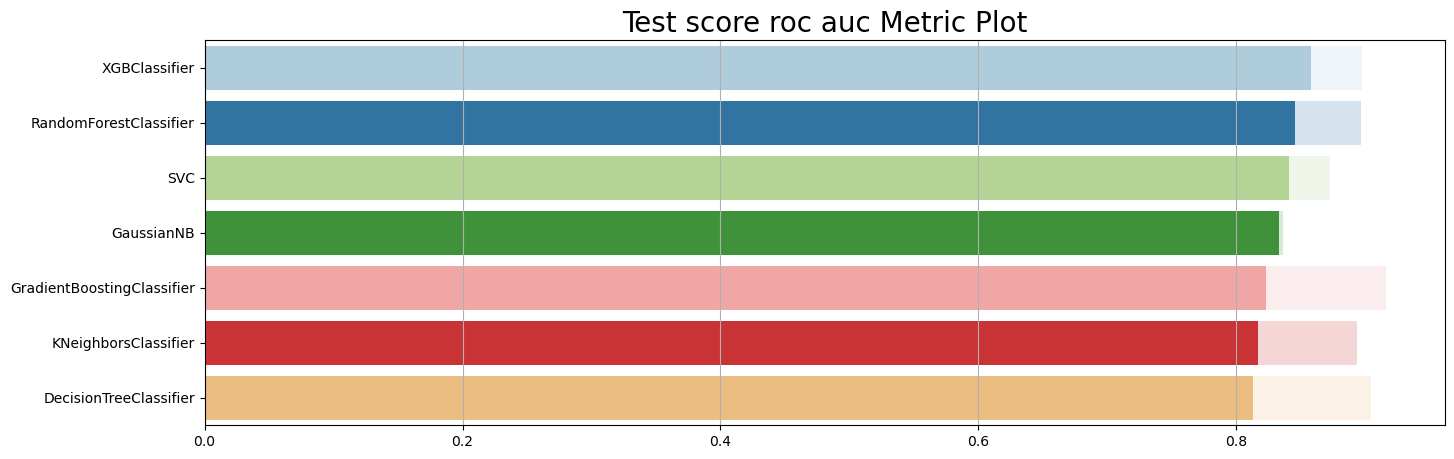

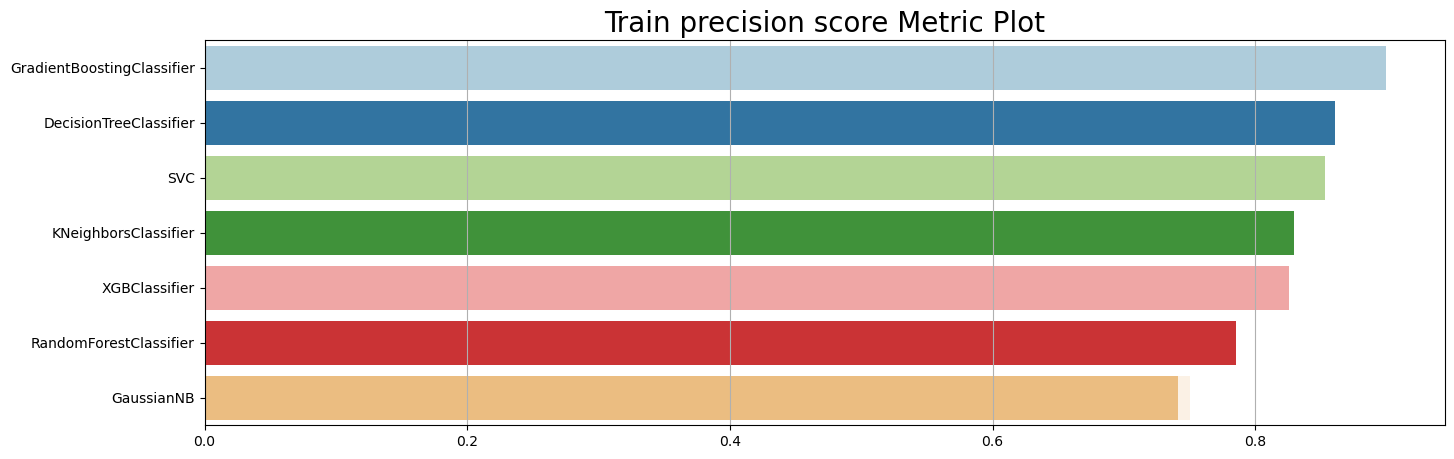

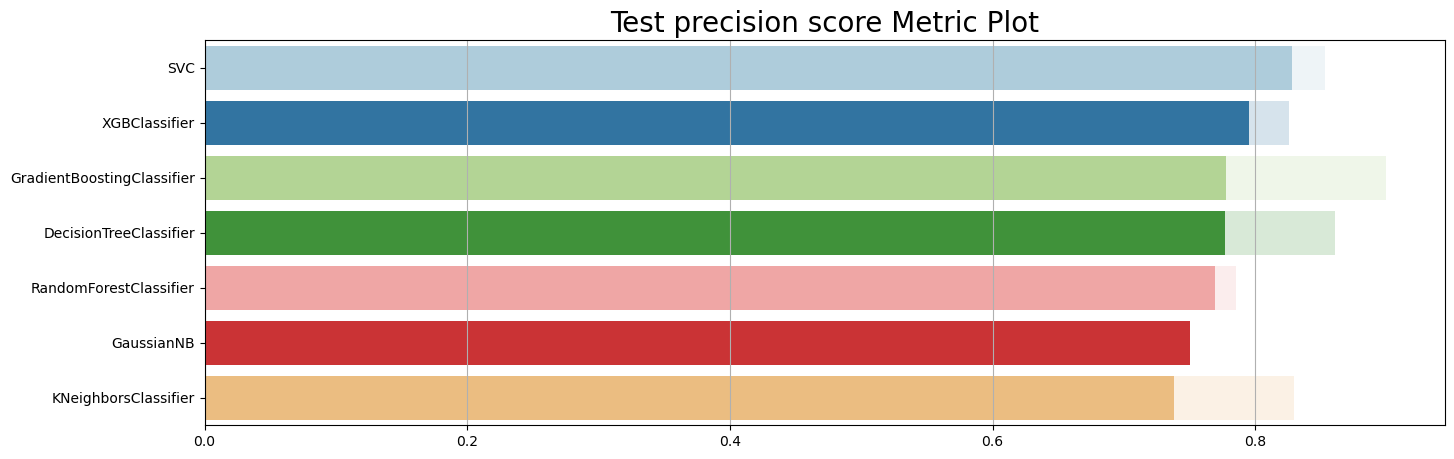

In [31]:
for metric in ['train_score_roc_auc','test_score_roc_auc','train_precision_score','test_precision_score']:
    eval_plot(evaluating_dict,metric)

In [59]:
# Show DataFrame 
pd.DataFrame(evaluating_dict).sort_values(by='test_score_roc_auc',ascending=False)

,algorithm_name,train_score_roc_auc,train_precision_score,test_score_roc_auc,test_precision_score,best_params
4,XGBClassifier,0.897911,0.825658,0.857751,0.795276,"{'XGBClassifier__colsample_bytree': 0.8, 'XGBC..."
2,RandomForestClassifier,0.896613,0.785294,0.845418,0.769231,{'RandomForestClassifier__criterion': 'entropy...
6,SVC,0.872921,0.853061,0.841256,0.828283,"{'SVC__C': 1, 'SVC__degree': 2, 'SVC__gamma': ..."
5,GaussianNB,0.836222,0.741176,0.833001,0.750000,"{'GaussianNB__var_smoothing': 1e-07, 'cat_impu..."
0,GradientBoostingClassifier,0.915812,0.899225,0.823489,0.777778,{'GradientBoostingClassifier__learning_rate': ...
3,KNeighborsClassifier,0.893431,0.829721,0.817018,0.738095,"{'KNeighborsClassifier__n_neighbors': 5, 'KNei..."
1,DecisionTreeClassifier,0.904709,0.860714,0.812662,0.776786,"{'DecisionTreeClassifier__criterion': 'gini', ..."


- <b>Conclusion</b>
    - Our algorithms have a performance of over 80%, which is considered to be very good, according to the Roc-auc metric data. I would like to emphasize that the 'XGBClassifier' and 'GaussianNB' are among the most stable algorithms. This is because their performance showed minimal difference between the training and testing results, which is an excellent indicator of the stability of the algorithms and their hyperparameters.